100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]
Epoch 1/20: 100%|██████████| 469/469 [00:08<00:00, 56.36it/s]


Epoch 1, Average Loss: 164.8882


Epoch 2/20: 100%|██████████| 469/469 [00:07<00:00, 63.04it/s]


Epoch 2, Average Loss: 121.7275


Epoch 3/20: 100%|██████████| 469/469 [00:07<00:00, 63.39it/s]


Epoch 3, Average Loss: 114.9744


Epoch 4/20: 100%|██████████| 469/469 [00:07<00:00, 63.84it/s]


Epoch 4, Average Loss: 111.8806


Epoch 5/20: 100%|██████████| 469/469 [00:07<00:00, 63.97it/s]


Epoch 5, Average Loss: 110.0766


Epoch 6/20: 100%|██████████| 469/469 [00:07<00:00, 64.50it/s]


Epoch 6, Average Loss: 108.8333


Epoch 7/20: 100%|██████████| 469/469 [00:07<00:00, 64.35it/s]


Epoch 7, Average Loss: 107.9548


Epoch 8/20: 100%|██████████| 469/469 [00:07<00:00, 64.95it/s]


Epoch 8, Average Loss: 107.2725


Epoch 9/20: 100%|██████████| 469/469 [00:07<00:00, 63.96it/s]


Epoch 9, Average Loss: 106.7206


Epoch 10/20: 100%|██████████| 469/469 [00:07<00:00, 63.79it/s]


Epoch 10, Average Loss: 106.3110


Epoch 11/20: 100%|██████████| 469/469 [00:07<00:00, 63.35it/s]


Epoch 11, Average Loss: 105.9066


Epoch 12/20: 100%|██████████| 469/469 [00:07<00:00, 64.99it/s]


Epoch 12, Average Loss: 105.5736


Epoch 13/20: 100%|██████████| 469/469 [00:07<00:00, 64.35it/s]


Epoch 13, Average Loss: 105.3206


Epoch 14/20: 100%|██████████| 469/469 [00:07<00:00, 64.28it/s]


Epoch 14, Average Loss: 105.0478


Epoch 15/20: 100%|██████████| 469/469 [00:07<00:00, 63.56it/s]


Epoch 15, Average Loss: 104.8370


Epoch 16/20: 100%|██████████| 469/469 [00:07<00:00, 63.84it/s]


Epoch 16, Average Loss: 104.6636


Epoch 17/20: 100%|██████████| 469/469 [00:07<00:00, 64.56it/s]


Epoch 17, Average Loss: 104.4634


Epoch 18/20: 100%|██████████| 469/469 [00:07<00:00, 63.70it/s]


Epoch 18, Average Loss: 104.3137


Epoch 19/20: 100%|██████████| 469/469 [00:07<00:00, 63.61it/s]


Epoch 19, Average Loss: 104.1537


Epoch 20/20: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]


Epoch 20, Average Loss: 104.0296


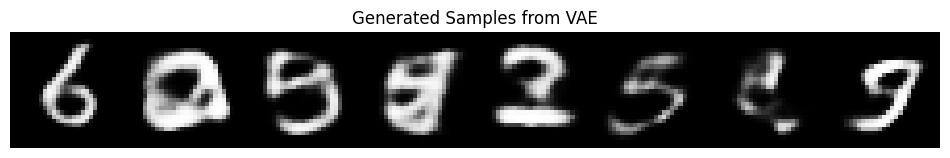

In [1]:
# Variational Autoencoder (VAE) for MNIST in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
latent_dim = 20
lr = 1e-3
epochs = 20

# Data
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mean
        self.fc22 = nn.Linear(400, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Average Loss: {train_loss / len(dataloader.dataset):.4f}")

# Sampling from latent space
model.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    sample = model.decode(z).cpu().view(-1, 1, 28, 28)

# Visualization
def show_images(images, title=""):
    grid = torch.cat([img.squeeze(0) for img in images], dim=1).cpu().numpy()
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

show_images(sample, title="Generated Samples from VAE")
